In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import openpyxl
from openpyxl import load_workbook
import os
#from ccfj import GetStationPairs
from geopy.distance import great_circle
#import shapefile
import geopandas as gp
import yaml
import math

from scipy.spatial import ConvexHull
from scipy.interpolate import griddata
from shapely.geometry import Point, Polygon

from pykrige.ok import OrdinaryKriging


In [2]:
import sys
sys.path.append(r'../tools_F-J/')
from toollib_standard import plotlib

In [3]:
flag_project = 1 # 0--regular; 1--repartrition

In [4]:
if flag_project == 0:
    file_project = 'a-project.yml'
elif flag_project == 1:
    file_project = 'a-project_repar.yml'
elif flag_project == 2:
    file_project = 'a-project_voro.yml'
    
with open(file_project, 'r', encoding='utf-8') as f:
    proj = yaml.load(f.read(), Loader=yaml.FullLoader)
name_project = proj['name']

#name_project = 'project/output_FJSJ_16-01/'               
#name_project = 'project_repartrition/repartrition_01-03/'               
#name_project = 'project_voronoi/voronoi_01-03/'         

In [5]:
with open('0_config.yml', 'r', encoding='utf-8') as f:
    dir_config = yaml.load(f.read(), Loader=yaml.FullLoader)
dir_project_workspace = dir_config['dir_project_workspace']
dir_CC_workspace = dir_config['dir_CC_workspace']
print('dir_CC_workspace: ', dir_CC_workspace)
print('dir_project_workspace: ', dir_project_workspace)
dir_project = os.path.join(dir_project_workspace, name_project)
print('dir_project: ', dir_project)

dir_CC_workspace:  /shdisk/rem2/Harmon/F-J/San/
dir_project_workspace:  /shdisk/rem2/Harmon/F-J/San/
dir_project:  /shdisk/rem2/Harmon/F-J/San/project_repartition_v4.0/output_repar_v9.2_01-01/


In [6]:
filename = dir_project+'Basic_info.yml'
with open(filename, 'r', encoding='utf-8') as f:
    info_basic = yaml.load(f.read(), Loader=yaml.FullLoader)
filename_bi = dir_project+'Basic_info.npy'
info_basic_bi = np.load(filename_bi, allow_pickle='TRUE').item()      # setting dictionary

In [7]:
dir_model_fund = dir_project + info_basic['dir_model_fund']
dir_model = dir_project + info_basic['dir_model']
dir_image = dir_project + info_basic['dir_image']+'Vs_compare/'
if not os.path.exists(dir_image):
    os.makedirs(dir_image)
dir_inv_dispernet = dir_project + info_basic['dir_inv_dispernet']
dir_partition = dir_project + info_basic['dir_partition']
key_subworks = info_basic['key_subworks']
M = len(key_subworks)
key_subworks

['1--08-03',
 '2--09-03',
 '3--10-03',
 '4--11-03',
 '5--12-03',
 '6--13-03',
 '7--14-03',
 '8--15-03',
 '9--16-03',
 '10--18-03',
 '12--20-03',
 '13--21-03',
 '15--23-03',
 '17--25-03',
 '18--26-03',
 '19--27-03',
 '20--28-03',
 '21--29-03',
 '22--30-03',
 '23--31-03',
 '25--33-03',
 '26--34-03',
 '28--36-03',
 '30--41-03',
 '31--42-03',
 '33--46-03',
 '34--47-03',
 '35--48-03',
 '36--52-03',
 '37--53-03',
 '38--07-04',
 '39--08-04',
 '40--09-04',
 '41--10-04',
 '42--12-04',
 '43--13-04',
 '44--17-04',
 '45--20-04',
 '46--21-04',
 '48--23-04',
 '49--24-04',
 '50--25-04',
 '51--27-04',
 '52--28-04',
 '53--29-04',
 '54--30-04',
 '55--31-04',
 '56--32-04',
 '57--33-04',
 '58--34-04',
 '59--35-04',
 '60--36-04',
 '63--47-04',
 '65--49-04',
 '66--52-04',
 '67--53-04',
 '68--08-05',
 '69--12-05',
 '70--13-05',
 '71--14-05',
 '72--16-05',
 '75--22-05',
 '76--24-05',
 '77--26-05',
 '78--27-05',
 '79--28-05',
 '80--29-05',
 '81--30-05',
 '84--35-05',
 '85--36-05',
 '86--37-05',
 '88--39-05',
 

In [8]:
def GetStationPairs(nsta):
    StationPair = []
    for ii in range(nsta):
        for jj in range(ii+1,nsta):
            StationPair.append(ii)
            StationPair.append(jj)
    StationPair = np.array(StationPair,dtype=np.int32)
    return StationPair

In [9]:
stalistname_all = info_basic['stalistname_all']
stainfo = pd.read_excel(stalistname_all)
nsta_all = len(stainfo.iloc[:,0])
StationPairs_all = GetStationPairs(nsta_all)
nPairs_all = int(len(StationPairs_all)/2)
stalist_all = stainfo['Station'].tolist() 
lat_stations_all =  stainfo['latitude'].tolist() 
lon_stations_all =  stainfo['longitude'].tolist() 

In [10]:
stations_partition = {}
lat_stations_partition = {}
lon_stations_partition = {}
lat_centroid_partition = []
lon_centroid_partition = []
num_stations = []
for key in key_subworks:
    filepath = dir_partition + str(key) + '.txt'
    stations_this, lat_stations_this, lon_stations_this = np.loadtxt(filepath, dtype='str' , unpack=True)
    stations_partition[key] = stations_this
    lat_stations_partition[key] = lat_stations_this.astype(float)
    lon_stations_partition[key] = lon_stations_this.astype(float)
    num_stations.append(len(stations_this))
    lat_centroid_partition.append(np.mean(lat_stations_this.astype(float)))
    lon_centroid_partition.append(np.mean(lon_stations_this.astype(float)))

In [11]:
#points = np.column_stack((lon_stations_all, lat_stations_all))
points = np.column_stack((lon_centroid_partition, lat_centroid_partition))
hull = ConvexHull(points)
polygon = Polygon(points[hull.vertices])
index_sta = []
lon_stations_in = []
lat_stations_in = []
elevation_stations_in = []
for i in range(len(lon_stations_all)):
    if polygon.contains(Point(lon_stations_all[i], lat_stations_all[i])):
        index_sta.append(i)
        lon_stations_in.append(lon_stations_all[i])
        lat_stations_in.append(lat_stations_all[i])

In [12]:
faults = np.load('clark_faults.npy', allow_pickle='TRUE').item()

In [13]:
inter_file = dir_inv_dispernet + 'vs_inter.npz'
inter = np.load(inter_file, allow_pickle=True)

In [14]:
vs_fund = inter['vs_fund']
vs = inter['vs']
lon_inter_in = inter['lon']
lat_inter_in = inter['lat']
z = inter['depth']
dz = inter['dz']
N = inter['N']

Plot horizon 1/2


ValueError: 'c' argument has 5597 elements, which is inconsistent with 'x' and 'y' with size 466.

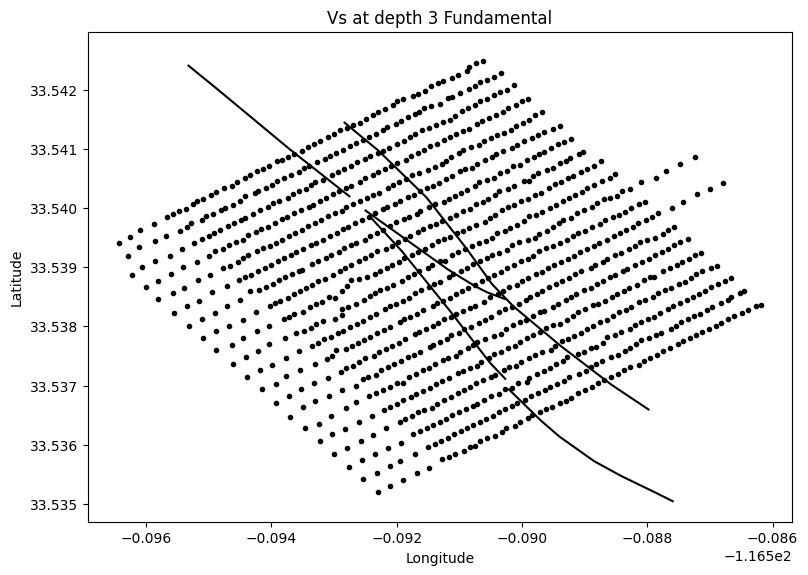

In [15]:
N = 2
for i in range(N):
    print('Plot horizon %d/%d' % (i+1,N))
    fig = plt.figure(figsize=(20, 14))
    ax = fig.add_subplot(221)
    ax.scatter(lon_stations_all, lat_stations_all,marker='.',color='k')
    #ax.set_xticks([])  #去掉横坐标值
    #ax.set_yticks([])  #去掉纵坐标值
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title('Vs at depth '+str((i+1)*dz)+' Fundamental')
    flag_add = 0.0005
    ax.set_xlim([min(lon_stations_all)-flag_add, max(lon_stations_all)+flag_add])
    ax.set_ylim([min(lat_stations_all)-flag_add, max(lat_stations_all)+flag_add])
    for j in range(len(faults)):
        ax.plot(faults['clark'+str(j+1)]['lon'], faults['clark'+str(j+1)]['lat'], 'k')
    im = ax.scatter(lon_centroid_partition,lat_centroid_partition,c=vs_fund_horizon[i,:],cmap='gist_rainbow',s=100)
    plt.colorbar(im)
    ax.set_title('Vs at depth '+str((i+1)*dz)+' Fundamental')
    ax.set_xticks([])  #去掉横坐标值
    ax.set_yticks([])  #去掉纵坐标值

    ax = fig.add_subplot(222)
    ax.scatter(lon_stations_all, lat_stations_all,marker='.',color='k')
    for j in range(len(faults)):
        ax.plot(faults['clark'+str(j+1)]['lon'], faults['clark'+str(j+1)]['lat'], 'k')
    #im = plt.scatter(lon_inter_in, lat_inter_in, s=10, c=vs_inter_horizon_in[i], cmap='gist_rainbow', vmin=v_min, vmax=v_max)
    im = plt.scatter(lon_inter_in, lat_inter_in, s=10, c=vs_fund[i,:], cmap='gist_rainbow')
    plt.colorbar(im)
    ax.set_xticks([])  #去掉横坐标值
    ax.set_yticks([])  #去掉纵坐标值
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title('Vs at depth '+str((i+1)*dz)+' Fundamental')
    

    ax = fig.add_subplot(223)
    ax.scatter(lon_stations_all, lat_stations_all,marker='.',color='k')
    #ax.set_xticks([])  #去掉横坐标值
    #ax.set_yticks([])  #去掉纵坐标值
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title('Vs at depth '+str((i+1)*dz)+' Fundamental')
    flag_add = 0.0005
    ax.set_xlim([min(lon_stations_all)-flag_add, max(lon_stations_all)+flag_add])
    ax.set_ylim([min(lat_stations_all)-flag_add, max(lat_stations_all)+flag_add])
    for j in range(len(faults)):
        ax.plot(faults['clark'+str(j+1)]['lon'], faults['clark'+str(j+1)]['lat'], 'k')
    im = ax.scatter(lon_centroid_partition,lat_centroid_partition,c=vs[i,:],cmap='gist_rainbow',s=100)
    plt.colorbar(im)
    ax.set_title('Vs at depth '+str((i+1)*dz)+' Overtones')
    ax.set_xticks([])  #去掉横坐标值
    ax.set_yticks([])  #去掉纵坐标值

    ax = fig.add_subplot(224)
    ax.scatter(lon_stations_all, lat_stations_all,marker='.',color='k')
    for j in range(len(faults)):
        ax.plot(faults['clark'+str(j+1)]['lon'], faults['clark'+str(j+1)]['lat'], 'k')
    #im = plt.scatter(lon_inter_in, lat_inter_in, s=10, c=vs_inter_horizon_in[i], cmap='gist_rainbow', vmin=v_min, vmax=v_max)
    im = plt.scatter(lon_inter_in, lat_inter_in, s=10, c=vs[i,:], cmap='gist_rainbow')
    plt.colorbar(im)
    ax.set_xticks([])  #去掉横坐标值
    ax.set_yticks([])  #去掉纵坐标值
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    plt.tight_layout()
    ax.set_title('Vs at depth '+str((i+1)*dz)+' Overtones')
    plt.savefig(dir_image+'Vs_hori_'+str((i+1)*dz)+'m.png',dpi=100)
    #plt.close()